In [20]:
pip install sentence-transformers umap-learn hdbscan rank_bm25 llama-cpp-python huggingface_hub pandas numpy scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.6 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.16-cp312-cp312-linux_x86_64.whl size=4503272 sha256=d8547c7212bfcbf01a0c6ca0f7e054df02dc2eb3115698e57fa4669980e08ff4
  Stored in directory: /root/.cache/pip/wheels/90/82/ab/8784ee3fb99ddb07fd36a679ddbe63122cc07718f6c1eb3be8
Successfully built llama-cpp-python


## # 1. Load the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import umap

file_path = 'combined_data_environment.csv'
df = pd.read_csv(file_path, sep=';', encoding='latin-1')

In [2]:
df.head()

,title,publication_date,byline,content,subject,country,city,person,industry,company,word_count,publication_date_text,publication,author,copyright
0,Egypt at the forefront of developing green and...,01.01.22,NaN,Egypt at the forefront of developing green and...,"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...","['EGYPT', 'AFRICA', 'MIDDLE EAST', 'NORTHERN A...","['GLASGOW, SCOTLAND']",[],"['GREEN FINANCE', 'BOND MARKETS', 'SUSTAINABLE...",[],1827,Jan 22,['Euromoney'],NaN,Copyright 2022 Euromoney Institutional Investo...
1,"Inequality, climate change and economic recove...",29.11.21,FinTech Futures,"Inequality, climate change and economic recove...","['CLIMATE CHANGE', 'GREEN FINANCE', 'ECONOMIC ...","['AFRICA', 'SOUTH AFRICA', 'EASTERN AFRICA', '...",[],[],"['SIC6021 NATIONAL COMMERCIAL BANKS', 'GREEN F...",['AFRICAN DEVELOPMENT BANK GROUP'],699,"November 29, 2021 Monday",['Fintechfutures.com'],FinTech Futures,Copyright 2021 Informal PLC All Rights Reserved
2,11th UK-India Economic and Financial Dialogue ...,02.09.21,NaN,11th UK-India Economic and Financial Dialogue ...,"['PUBLIC FINANCE', 'COVID CORONAVIRUS', 'COVID...","['UNITED KINGDOM', 'INDIA', 'BRICS MEMBER STAT...","['LONDON, ENGLAND']",[],"['PUBLIC FINANCE AGENCIES & TREASURIES', 'TREA...",[],3560,"September 2, 2021 Thursday",['Impact News Service'],NaN,Copyright 2021 Impact Media Limited All Rights...
3,"""Being the Change We Want to See: A Sustainabl...",09.06.21,NaN,"""Being the Change We Want to See: A Sustainabl...","['SUSTAINABILITY', 'SUSTAINABLE DEVELOPMENT', ...","['SINGAPORE', 'ASIA', 'UNITED STATES']",[],[],"['SUSTAINABLE DEVELOPMENT', 'EMISSIONS', 'BANK...",[],3693,"June 9, 2021 Wednesday",['Singapore Government News'],NaN,"Copyright 2021 Singapore Government News, dist..."
4,Together we can mobilise capital and achieve n...,11.01.22,AXEL A. WEBER,Together we can mobilise capital and achieve n...,"['SUSTAINABLE DEVELOPMENT', 'AGREEMENTS', 'CLI...","['CHINA', 'UNITED STATES', 'ASIA', 'EUROPE']",[],[],"['SUSTAINABLE DEVELOPMENT', 'BANKING & FINANCE...",[],1004,"January 11, 2022 Tuesday",['The Australian'],AXEL A. WEBER,Copyright 2022 Nationwide News Pty Limited All...


In [3]:
df.shape

(2969, 15)

# 2. Prepare text for embedding (Title + " " + Content)

In [4]:
df['combined_text'] = df['title'].fillna('') + " " + df['content'].fillna('')
texts = df['combined_text'].tolist()

# 3. Generate Embeddings using all-MiniLM-L6-v2

In [5]:
print("Generating embeddings... (This may take a few minutes on Colab CPU)")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)

Generating embeddings... (This may take a few minutes on Colab CPU)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

# 4. UMAP Dimensionality Reduction

In [6]:
# 50D projection for HDBSCAN clustering (to reduce curse of dimensionality)
print("Creating 50D projection...")
umap_50d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=50,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

# 2D projection for visualization
print("Creating 2D projection...")
umap_2d = umap.UMAP(
    n_neighbors=20,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

Creating 50D projection...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Creating 2D projection...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# 5. Visualize the 2D Projection

/tmp/ipython-input-855535463.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=5, alpha=0.6, cmap='Spectral')


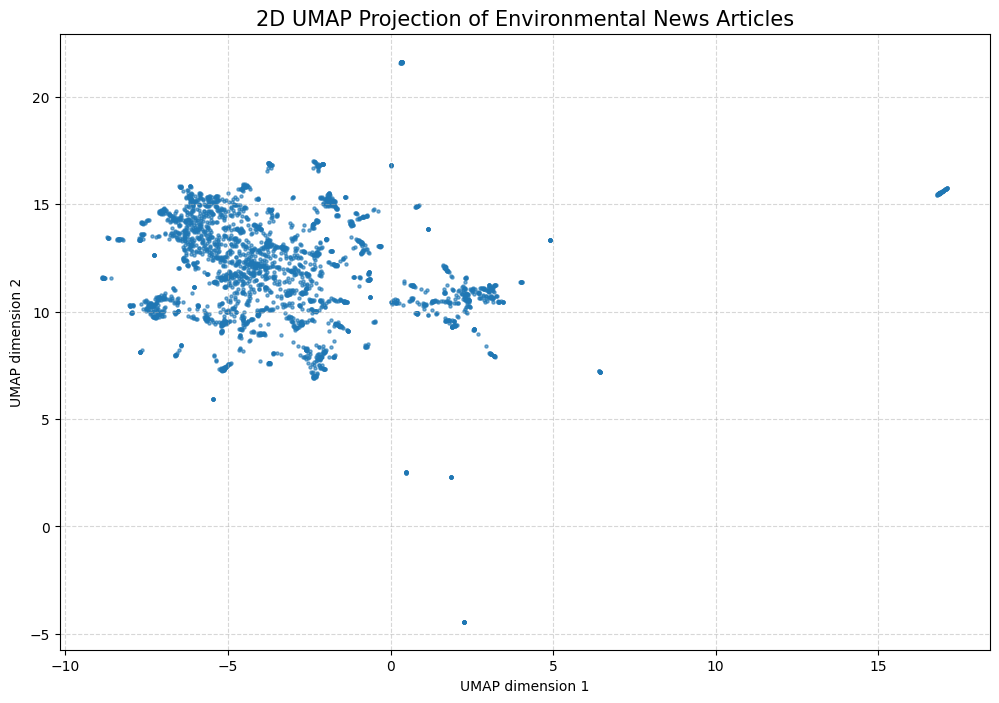

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=5, alpha=0.6, cmap='Spectral')
plt.title('2D UMAP Projection of Environmental News Articles', fontsize=15)
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('umap_2d_projection.png')
plt.show()

 # Core Distance Computation and Visualization

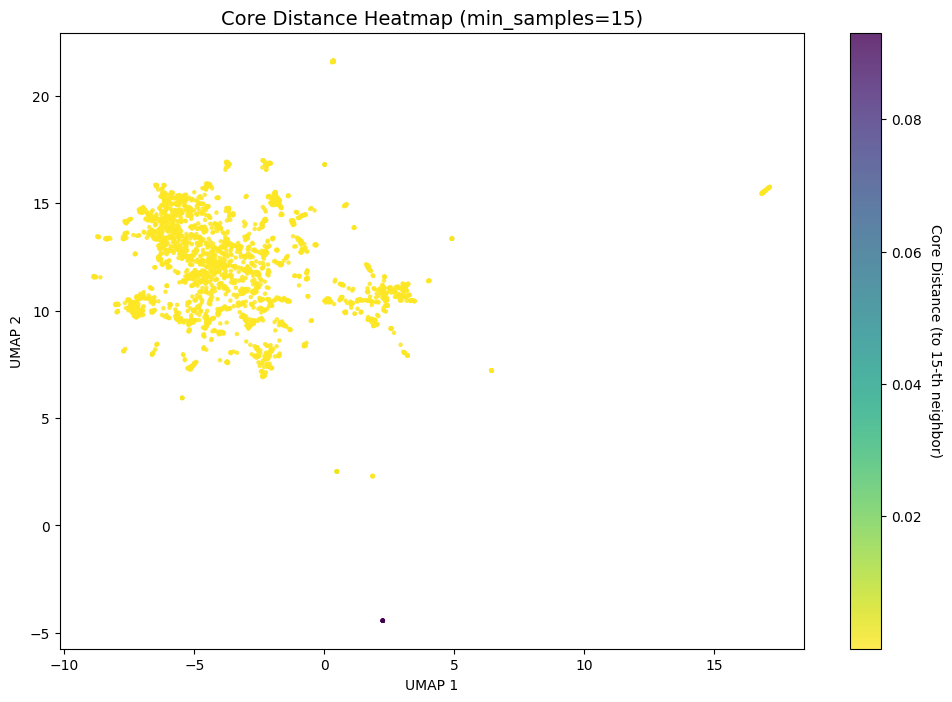

In [8]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def compute_core_distances(X, min_samples):
    """
    Compute core distance for each point.
    Core distance = distance to the k-th nearest neighbor (including itself).
    """
    # Initialize NearestNeighbors
    # n_neighbors is min_samples (k)
    nn = NearestNeighbors(n_neighbors=min_samples, metric='cosine')
    nn.fit(X)

    # kneighbors returns (distances, indices)
    # The last column [:, -1] is the distance to the k-th neighbor
    distances, _ = nn.kneighbors(X)
    core_distances = distances[:, -1]

    return core_distances

# --- Execution ---

# Define min_samples (standard starting point for ~3,000 points)
min_samples = 15

# We compute core distances on the 50D projection as requested for HDBSCAN
core_dist = compute_core_distances(umap_50d, min_samples)

# --- Visualization ---

plt.figure(figsize=(12, 8))
# Using 'viridis_r' (reversed) so smaller distances are darker/more intense
scatter = plt.scatter(umap_2d[:, 0], umap_2d[:, 1],
                      c=core_dist, cmap='viridis_r', s=5, alpha=0.8)

# Formatting
cbar = plt.colorbar(scatter)
cbar.set_label(f'Core Distance (to {min_samples}-th neighbor)', rotation=270, labelpad=15)
plt.title(f'Core Distance Heatmap (min_samples={min_samples})', fontsize=14)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.savefig('core_distance_heatmap.png')
plt.show()

# Mutual Reachability Distance Computation and Visualization


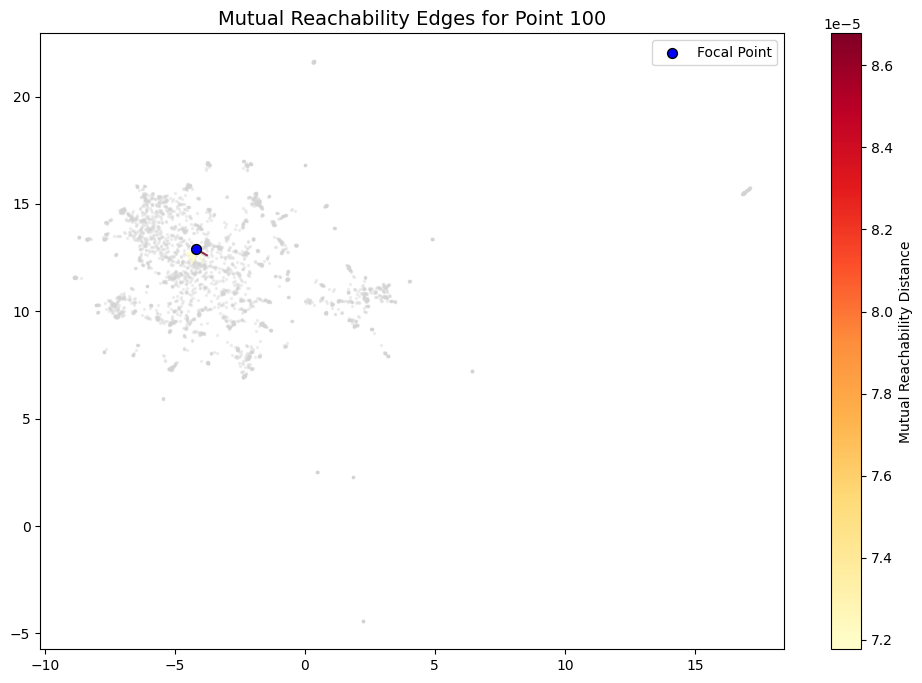

In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import matplotlib.lines as mlines

def compute_mutual_reachability(X, core_distances, n_neighbors=15):
    """
    Compute mutual reachability distances for neighboring points.
    Returns list of edges: (point_i, point_j, euclidean_dist, mutual_reach_dist)
    """
    # Find the nearest neighbors for each point to form edges
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='cosine')
    nn.fit(X)

    # kneighbors returns (distances, indices)
    dist, indices = nn.kneighbors(X)

    edges = []
    for i in range(len(X)):
        # Skip the first index because it's the point itself
        for neighbor_idx, d_ij in zip(indices[i, 1:], dist[i, 1:]):
            # dmreach(i,j) = max(core_dist_i, core_dist_j, d(i,j))
            m_reach = max(core_distances[i], core_distances[neighbor_idx], d_ij)
            edges.append((i, neighbor_idx, d_ij, m_reach))

    return edges

# --- Execution ---

# 1. Compute edges and mutual reachability
# We use the 50D data and the core_dist calculated in Task 2
all_edges = compute_mutual_reachability(umap_50d, core_dist, n_neighbors=15)

# 2. Select a Focal Point
# Let's pick a point in a semi-sparse area to visualize the 'inflation' effect
focal_idx = 100
focal_edges = [edge for edge in all_edges if edge[0] == focal_idx]

# --- Visualization ---

plt.figure(figsize=(12, 8))

# Plot all points in the background in light gray
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c='lightgrey', s=2, alpha=0.3)

# Extract coordinates for the focal point and its neighbors in 2D
x_focal, y_focal = umap_2d[focal_idx]

# Plot edges for the focal point
# Normalize mutual reach distances for coloring
m_reach_vals = [e[3] for e in focal_edges]
norm = plt.Normalize(vmin=min(m_reach_vals), vmax=max(m_reach_vals))
cmap = plt.get_cmap('YlOrRd')

for start_idx, end_idx, d_ij, m_reach in focal_edges:
    x_neighbor, y_neighbor = umap_2d[end_idx]
    plt.plot([x_focal, x_neighbor], [y_focal, y_neighbor],
             color=cmap(norm(m_reach)), linewidth=1.5, alpha=0.8)

# Highlight focal point
plt.scatter(x_focal, y_focal, c='blue', s=50, edgecolors='black', label='Focal Point', zorder=5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax = plt.gca() # Get the current axes
plt.colorbar(sm, ax=ax, label='Mutual Reachability Distance')
plt.title(f'Mutual Reachability Edges for Point {focal_idx}', fontsize=14)
plt.legend()
plt.savefig('mutual_reachability_edges.png')
plt.show()

# HDBSCAN Parameter Sensitivity Analysis

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Starting Systematic Search...


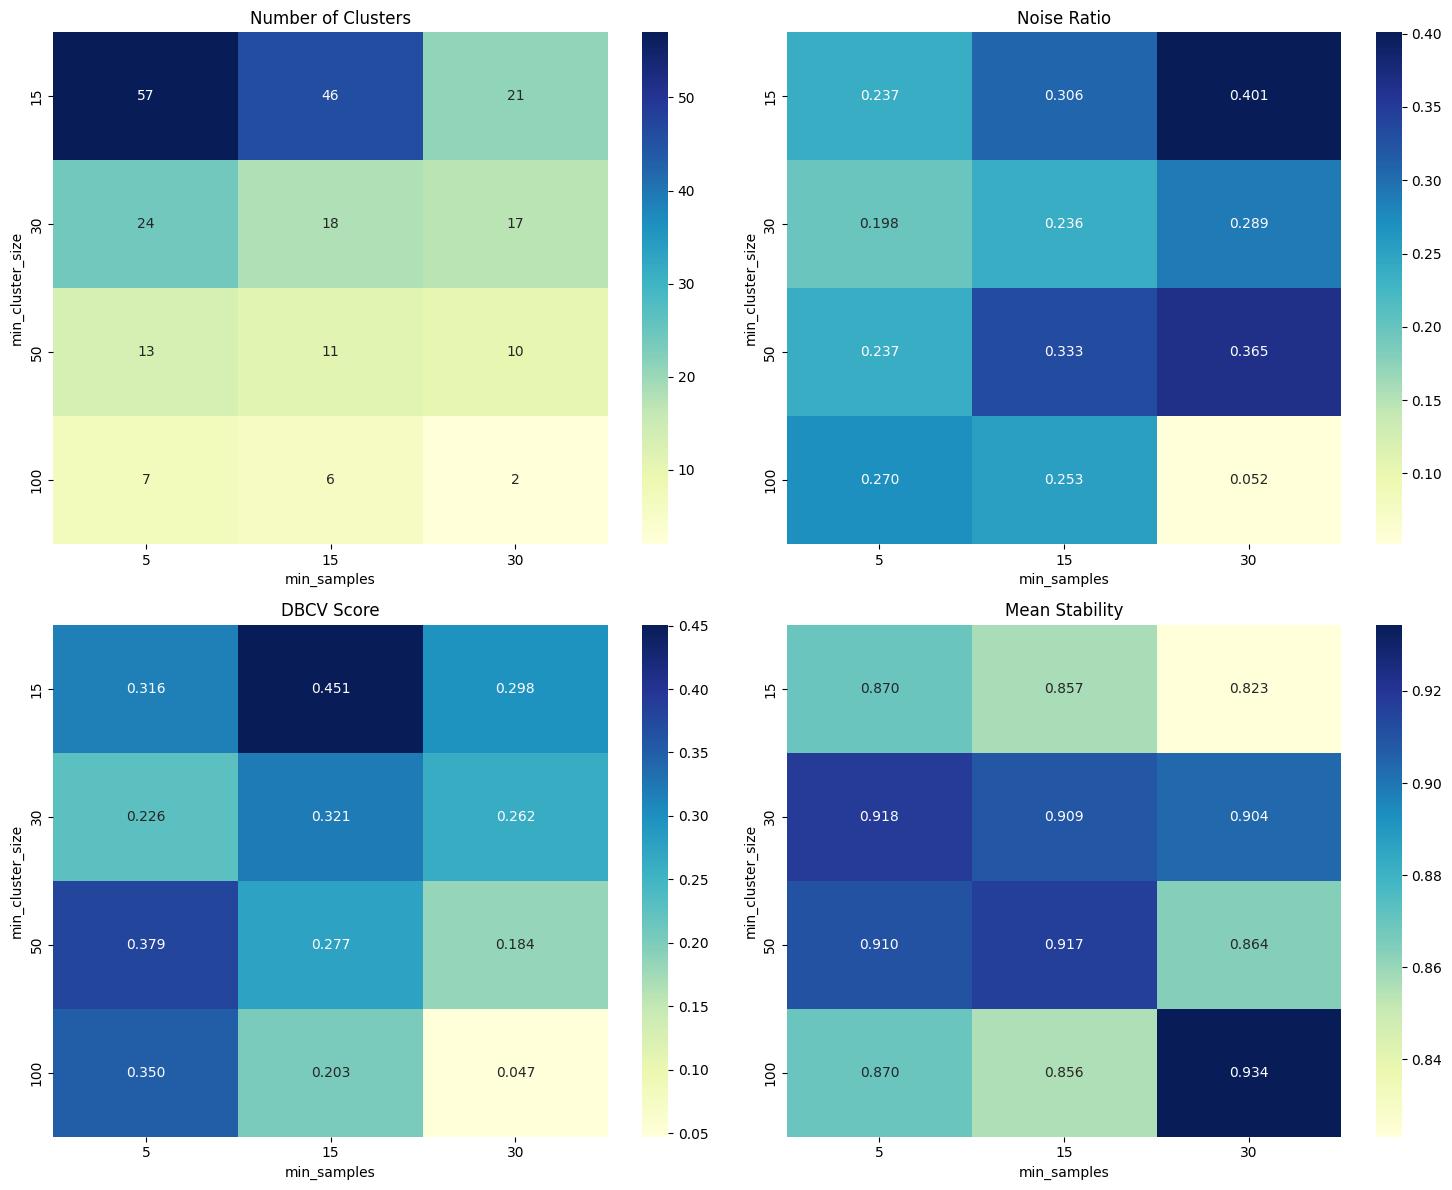

In [10]:
import hdbscan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the Parameter Grid
min_cluster_sizes = [15, 30, 50, 100]
min_samples_values = [5, 15, 30]

results = []

print("Starting Systematic Search...")
for mcs in min_cluster_sizes:
    for ms in min_samples_values:
        # Initialize and fit HDBSCAN
        # Note: gen_min_span_tree=True is required for DBCV (relative_validity_)
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            metric='euclidean', # Using the 50D UMAP projection
            gen_min_span_tree=True
        )
        labels = clusterer.fit_predict(umap_50d)

        # Calculate Metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.sum(labels == -1) / len(labels)

        # HDBSCAN provides a fast DBCV approximation via relative_validity_
        dbcv_score = clusterer.relative_validity_

        # Mean stability of points (excluding noise)
        if n_clusters > 0:
            mean_stability = np.mean(clusterer.probabilities_[labels != -1])
        else:
            mean_stability = 0

        results.append({
            'min_cluster_size': mcs,
            'min_samples': ms,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio,
            'dbcv': dbcv_score,
            'stability': mean_stability
        })

# 2. Convert to DataFrame for visualization
results_df = pd.DataFrame(results)

# 3. Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['n_clusters', 'noise_ratio', 'dbcv', 'stability']
titles = ['Number of Clusters', 'Noise Ratio', 'DBCV Score', 'Mean Stability']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    pivot = results_df.pivot(index="min_cluster_size", columns="min_samples", values=metric)
    sns.heatmap(pivot, annot=True, fmt=".3f" if i > 0 else "d", cmap="YlGnBu", ax=ax)
    ax.set_title(titles[i])

plt.tight_layout()
plt.savefig('parameter_space.png')
plt.show()

# Custom Scoring Function for HDBSCAN Configuration Selection


In [11]:
def score_configuration(row):
    # Normalize and Weight Metrics
    # Weighting: DBCV (40%), Stability (30%), Noise Penalty (20%), Cluster Balance (10%)

    # We penalize configurations with 0 or 1 clusters (useless for discovery)
    if row['n_clusters'] <= 1:
        return -1

    # We penalize excessive noise (if > 50% of data is lost, it's too conservative)
    noise_penalty = 1 - row['noise_ratio']

    # Final Weighted Score
    total_score = (row['dbcv'] * 0.4) + (row['stability'] * 0.3) + (noise_penalty * 0.3)
    return total_score

results_df['custom_score'] = results_df.apply(score_configuration, axis=1)
best_config = results_df.loc[results_df['custom_score'].idxmax()]

print("\n--- Best Configuration ---")
print(best_config)


--- Best Configuration ---
min_cluster_size    50.000000
min_samples          5.000000
n_clusters          13.000000
noise_ratio          0.236780
dbcv                 0.378581
stability            0.910334
custom_score         0.653499
Name: 6, dtype: float64


# Optimized HDBSCAN Model and Minimum Spanning Tree Visualization


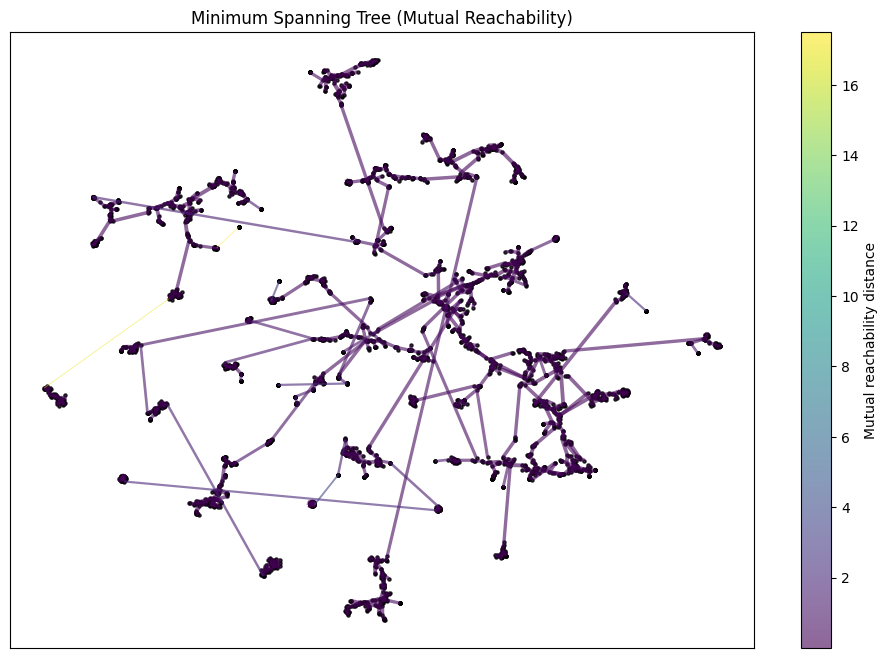

In [12]:
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Fit the optimized model
optimized_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=5,
    metric='euclidean',
    gen_min_span_tree=True,
    prediction_data=True
)
labels = optimized_clusterer.fit_predict(umap_50d)

# --- 5.1 Minimum Spanning Tree (MST) ---
plt.figure(figsize=(12, 8))
# We visualize the MST for the entire dataset, but you can filter for one cluster if desired.
# plot() is a built-in method that uses mutual reachability for edge weights
optimized_clusterer.minimum_spanning_tree_.plot(
    edge_cmap='viridis',
    edge_alpha=0.6,
    node_size=5,
    edge_linewidth=0.5
)
plt.title("Minimum Spanning Tree (Mutual Reachability)")
plt.savefig('mst.png')
plt.show()

# 5.2 Condensed Tree


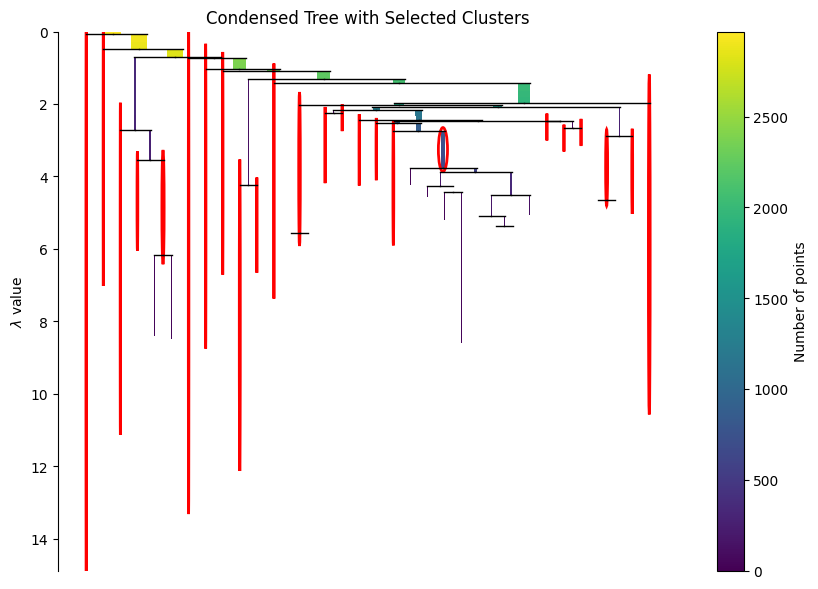

In [13]:
plt.figure(figsize=(10, 7))
optimized_clusterer.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette('deep', 21)
)
plt.title("Condensed Tree with Selected Clusters")
plt.savefig('condensed_tree.png')
plt.show()

# Extract tree structure as DataFrame for analysis
tree_df = optimized_clusterer.condensed_tree_.to_pandas()

# 5.3 Cluster Selection with Lambda Values

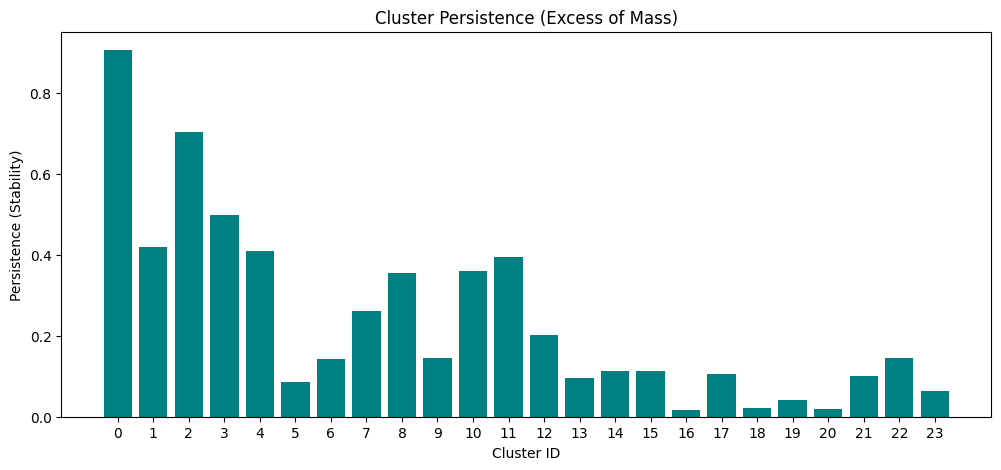

In [14]:
# Get persistence (stability) values for the selected clusters
persistence = optimized_clusterer.cluster_persistence_

plt.figure(figsize=(12, 5))
plt.bar(range(len(persistence)), persistence, color='teal')
plt.xlabel('Cluster ID')
plt.ylabel('Persistence (Stability)')
plt.title('Cluster Persistence (Excess of Mass)')
plt.xticks(range(len(persistence)))
plt.savefig('cluster_persistence.png')
plt.show()

In [15]:
pip install rank_bm25

## part 2

# 1. Setup BM25 (Lexical Search)
# Tokenize the combined_text created in Part 1

In [16]:
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi
from sklearn.metrics.pairwise import cosine_similarity

tokenized_corpus = [doc.lower().split() for doc in df['combined_text']]
bm25 = BM25Okapi(tokenized_corpus)

def normalize_scores(scores):
    """Apply Min-Max normalization to bring scores to [0, 1] range."""
    s_min, s_max = np.min(scores), np.max(scores)
    if s_max - s_min == 0:
        return np.zeros_like(scores)
    return (scores - s_min) / (s_max - s_min)

def hybrid_search(query, top_k=5, alpha=0.5):
    """
    Combines BM25 and Semantic Search scores.
    alpha=1.0: Pure Semantic
    alpha=0.0: Pure BM25
    """
    # --- BM25 Component ---
    tokenized_query = query.lower().split()
    bm25_raw_scores = np.array(bm25.get_scores(tokenized_query))
    bm25_norm = normalize_scores(bm25_raw_scores)

    # --- Semantic Component ---
    # Use the same model from Part 1 to encode the query
    query_embedding = model.encode([query])
    # Compute cosine similarity against ALL document embeddings from Part 1
    semantic_raw_scores = cosine_similarity(query_embedding, embeddings).flatten()
    semantic_norm = normalize_scores(semantic_raw_scores)

    # --- Hybrid Combination ---
    final_scores = (alpha * semantic_norm) + ((1 - alpha) * bm25_norm)

    # Get top_k indices
    top_indices = np.argsort(final_scores)[::-1][:top_k]

    # Return a formatted result
    results = df.iloc[top_indices].copy()
    results['hybrid_score'] = final_scores[top_indices]
    return results[['title', 'hybrid_score']]

# --- Demonstration ---
query_example = "Impact of carbon tax on European manufacturing"

print("Results with alpha=0.1 (Keyword Focused):")
display(hybrid_search(query_example, alpha=0.1))

print("\nResults with alpha=0.9 (Semantic Focused):")
display(hybrid_search(query_example, alpha=0.9))

Results with alpha=0.1 (Keyword Focused):


,title,hybrid_score
452,The slow transition to an EV hub,0.962967
563,Sustainable financing and investing continues ...,0.839080
206,"November 13, 2023: Cadwalader Earns Top Scores...",0.786003
160,EU eyes SLB label in big expansion of sustaina...,0.779591
204,Greening the economy,0.770630



Results with alpha=0.9 (Semantic Focused):


,title,hybrid_score
2125,Council of the European Union: Proposal for a ...,0.954677
149,European Union: Questions and answers on EU an...,0.910660
778,"""Greening finance for sustainable business"" - ...",0.899692
251,Gas industry storms into EU green finance taxo...,0.892144
150,Questions and answers on EU and Climate finance,0.889879


# Two-Stage Retrieval with Cross-Encoder Reranking


In [17]:
from sentence_transformers import CrossEncoder

# 1. Load the Cross-Encoder model
# This model is specifically trained for the MS MARCO passage ranking task
reranker_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def rerank_search(query, top_k=3, candidates=20):
    """
    Two-stage retrieval:
    Stage 1: Hybrid search (fast retrieval)
    Stage 2: Cross-Encoder (precise reranking)
    """
    # --- Stage 1: Initial Retrieval ---
    # We use alpha=0.5 for a balanced hybrid start
    initial_results = hybrid_search(query, top_k=candidates, alpha=0.5)

    # Prepare pairs for the Cross-Encoder: [query, document_text]
    candidate_texts = df.loc[initial_results.index, 'combined_text'].tolist()
    pairs = [[query, text] for text in candidate_texts]

    # --- Stage 2: Reranking ---
    # The Cross-Encoder outputs a relevance score for each pair
    rerank_scores = reranker_model.predict(pairs)

    # Add scores to the results and re-sort
    initial_results['rerank_score'] = rerank_scores
    final_results = initial_results.sort_values(by='rerank_score', ascending=False)

    return final_results.head(top_k), initial_results.head(top_k)

# --- Demonstration ---
query_test = "How does biodiversity loss affect financial stability in the EU?"
reranked_top, initial_top = rerank_search(query_test)

print("=== Top 3 BEFORE Reranking (Hybrid Only) ===")
print(initial_top[['title', 'hybrid_score']])

print("\n=== Top 3 AFTER Reranking (Cross-Encoder) ===")
print(reranked_top[['title', 'rerank_score']])

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

=== Top 3 BEFORE Reranking (Hybrid Only) ===
                                                 title  hybrid_score
291  PRESS RELEASE: FINANCIAL INSTITUTIONS SHARE TH...      0.998362
238  De Nederlandsche Bank: Financial institutions ...      0.994168
106  Centre for Sustainable Finance, Finance for Bi...      0.885846

=== Top 3 AFTER Reranking (Cross-Encoder) ===
                                                  title  rerank_score
1270           Finance: becoming green while in the red      2.483501
291   PRESS RELEASE: FINANCIAL INSTITUTIONS SHARE TH...      1.693577
238   De Nederlandsche Bank: Financial institutions ...      1.653155


# Temporal-Aware Hybrid Search with Exponential Time Decay


In [18]:
import pandas as pd
import numpy as np
from datetime import datetime

# 1. Pre-process Dates
# Assuming 'publication_date' column exists. We convert to datetime and extract year.
df['pub_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
df['pub_year'] = df['pub_date'].dt.year

# Fill missing years with the median to avoid NaN errors
median_year = df['pub_year'].median()
df['pub_year'] = df['pub_year'].fillna(median_year).astype(int)

# 2026 is our current reference year
CURRENT_YEAR = 2026

def temporal_search(query, top_k=3, alpha=0.5, decay_rate=0.9):
    """
    Hybrid search with exponential time decay weighting.
    Formula: final_score = hybrid_score * (decay_rate ^ age)
    """
    # Get initial hybrid search results (we'll take more than top_k to allow for re-ranking)
    initial_candidates = 50
    results = hybrid_search(query, top_k=initial_candidates, alpha=alpha)

    # Merge with year data
    results = results.join(df[['pub_year']])

    # Calculate Age and Decay Weight
    results['age'] = CURRENT_YEAR - results['pub_year']
    # If age is negative (future date), set to 0
    results['age'] = results['age'].clip(lower=0)

    results['time_decay_weight'] = decay_rate ** results['age']

    # Apply Weighting
    results['temporal_score'] = results['hybrid_score'] * results['time_decay_weight']

    # Sort by the new temporal score
    final_results = results.sort_values(by='temporal_score', ascending=False)

    return final_results.head(top_k)

# --- Demonstration ---
query_temp = "Recent updates on carbon credit regulations"

print("--- Decay Rate 0.95 (High Relevance, Low Recency Bias) ---")
display(temporal_search(query_temp, decay_rate=0.95))

print("\n--- Decay Rate 0.70 (Aggressive Recency Bias) ---")
display(temporal_search(query_temp, decay_rate=0.70))

/tmp/ipython-input-957896055.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['pub_date'] = pd.to_datetime(df['publication_date'], errors='coerce')


--- Decay Rate 0.95 (High Relevance, Low Recency Bias) ---


,title,hybrid_score,pub_year,age,time_decay_weight,temporal_score
1815,"Global Regulatory Brief: Green Finance, Januar...",0.844411,2024,2,0.902500,0.762081
2160,World Council of Credit Unions Releases Guide ...,0.856066,2023,3,0.857375,0.733969
2274,World Council of Credit Unions Releases Guide ...,0.848247,2023,3,0.857375,0.727265



--- Decay Rate 0.70 (Aggressive Recency Bias) ---


,title,hybrid_score,pub_year,age,time_decay_weight,temporal_score
1815,"Global Regulatory Brief: Green Finance, Januar...",0.844411,2024,2,0.490,0.413761
1253,Our policy progress in 2023 and outlook for 2024,0.755676,2024,2,0.490,0.370281
2160,World Council of Credit Unions Releases Guide ...,0.856066,2023,3,0.343,0.293630


# Retrieval-Augmented Generation (RAG) with Qwen LLM


In [22]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import textwrap

# 1. Download and Load the LLM (Qwen 2.5 0.5B)
model_path = hf_hub_download(
    repo_id="Qwen/Qwen2.5-0.5B-Instruct-GGUF",
    filename="qwen2.5-0.5b-instruct-q4_k_m.gguf"
)

# Initialize with 2048 context length to handle a few news articles
llm = Llama(model_path=model_path, n_ctx=2048, verbose=False)

def rerank_search(query, top_k=3, candidates=20):
    """
    Two-stage retrieval:
    Stage 1: Hybrid search (fast retrieval)
    Stage 2: Cross-Encoder (precise reranking)
    """
    # --- Stage 1: Initial Retrieval ---
    # We use alpha=0.5 for a balanced hybrid start
    # hybrid_search returns a DataFrame with 'title' and 'hybrid_score' and the original index
    hybrid_results_partial = hybrid_search(query, top_k=candidates, alpha=0.5)

    # Get the full rows from the original df using the indices from hybrid_results_partial
    # This will include 'combined_text' and all other columns
    initial_results_full = df.loc[hybrid_results_partial.index].copy()
    initial_results_full['hybrid_score'] = hybrid_results_partial['hybrid_score']

    # Prepare pairs for the Cross-Encoder: [query, document_text]
    candidate_texts = initial_results_full['combined_text'].tolist()
    pairs = [[query, text] for text in candidate_texts]

    # --- Stage 2: Reranking ---
    # The Cross-Encoder outputs a relevance score for each pair
    rerank_scores = reranker_model.predict(pairs)

    # Add scores to the results and re-sort
    initial_results_full['rerank_score'] = rerank_scores
    final_results = initial_results_full.sort_values(by='rerank_score', ascending=False)

    return final_results.head(top_k), initial_results_full.head(top_k)

def rag(query, top_k=2):
    """
    RAG Pipeline:
    1. Retrieve using two-stage (Hybrid + Rerank)
    2. Build context-aware prompt
    3. Generate response with citations
    """
    # Step 1: Retrieval (Reusing your Task 2 reranker)
    # We take top_k=2 because small models struggle with too much context
    results, _ = rerank_search(query, top_k=top_k, candidates=10)

    # Step 2: Format Context
    context_blocks = []
    for i, (idx, row) in enumerate(results.iterrows(), 1):
        # We truncate content slightly to keep the prompt tight
        content_snippet = row['combined_text'][:1500]
        block = f"[{i}] Title: {row['title']}\nContent: {content_snippet}"
        context_blocks.append(block)

    context_str = "\n\n".join(context_blocks)

    # Step 3: Create the Prompt
    prompt = f"""You are a helpful assistant. Use ONLY the provided sources to answer the question.
If the answer is not in the sources, say "Cannot answer from sources."
Always use [N] to cite the source number.

SOURCES:
{context_str}

QUESTION: {query}

ANSWER:"""

    # Step 4: Generation
    output = llm(
        prompt,
        max_tokens=256,
        temperature=0.1, # Low temperature for factual accuracy
        stop=["SOURCES:", "QUESTION:"]
    )

    answer = output["choices"][0]["text"].strip()
    return answer, results

# --- Demonstration 1: Successful Citation ---
query_rag = "What are the specific requirements for Green Bond issuance according to these reports?"
answer, sources = rag(query_rag)
print(f"Query: {query_rag}\n\nAnswer:\n{textwrap.fill(answer, 80)}")
print("\nSources used for verification:")
display(sources[['title']])

print("-" * 30)

# --- Demonstration 2: Unanswerable Question ---
query_noise = "Who won the FIFA World Cup in 1998?"
answer_noise, _ = rag(query_noise)
print(f"Query: {query_noise}\nAnswer: {answer_noise}")

llama_context: n_ctx_per_seq (2048) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


Query: What are the specific requirements for Green Bond issuance according to these reports?

Answer:
There is still much to debate in the development of an asset class that will
support the transition to a low-carbon economy, as Marie Kemplay discovers.
SINCE THE FIRST GREEN BOND WAS ISSUED in 2007, the market has exploded in value,
with $205.1bn-worth of issuance in 2019, accor ding to Dealogic. That was the
first year the $200bn mark had been reached, and a 38% increase on 2018. While
green bonds are still only a tiny fraction of the total bond market, insatiable
investor demand is likely to keep pushing issuance up. This is good news for
those who subscribe to the increasingly uncontroversial view that there is an
urgent need for economies globally to operate far more sustainably. But it is
also clear that solely funding projects and organisations that can neatly be
classified as 'green' will move things only so far: the real dirty work still
lies ahead. BEYOND BONDS To meet the a

,title
2892,Sustainable finance: moving towards a common l...
216,IS 'TRANSITION' THE NEW GREEN FOR BONDS? Issua...


------------------------------
Query: Who won the FIFA World Cup in 1998?
Answer: Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sources. [N] Cannot answer from sou